# Scratch CNN

In this notebook we will address the problem of training a CNN from scratch to classify breast abnormalities, we will distinguish between mass and calcification.

In [ ]:
# Needed to import the utils file
!pip install import-ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=6b5c8e5e9c23001832b6dfc2bbaaa944b772e0fb1e5188a2c41d40d3991aecad
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Move in the folder to import the utils file
%cd '/content/gdrive/MyDrive/Colab Notebooks'

/content/gdrive/MyDrive/Colab Notebooks


In [ ]:
import import_ipynb
import Utils as ut
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential

importing Jupyter notebook from Utils.ipynb
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Data preprocessing
We apply to the dataset the following preprocessing steps:

* Binarize the dataset: initially it contains 5 classes (baseline, mass_benign, mass_malignant, calcification_benign, calcification_malignant), we will discard the baselines patches (healthy tissue) and we will binarize the 4 classes of abnormalities into 2 classes (mass, calcification).

* We normalize between [0,1] the tensors.
* We add the channel dimension to the tensors, from (150,150) to (150,150,1).

In [ ]:
images, labels = ut.load_training()
test_images, test_labels = ut.load_test()

In [ ]:
dataset, lab = ut.binarize(images, labels, 'mass_calcification')

In [ ]:
dataset, lab = ut.shuffle_dataset(dataset, lab) # The dataset is ordered by class, we need to shuffle it.
dataset = ut.rescale(dataset)
dataset = np.expand_dims(dataset, axis=3)
ut.properties(dataset)

Properties: 
Shape: (2676, 150, 150, 1)
Min: 0.0
Max: 1.0
Diff: 1.0
Type of elements: float64


## Training
As the dataset is unbalanced, we will perform the training (and the evaluation) with weighted classes.

In [ ]:
mc_weights = class_weight.compute_class_weight('balanced', np.unique(lab), lab)
mc_weights = dict(enumerate(mc_weights))
print('Class weights: ', mc_weights)

Class weights:  {0: 1.0985221674876848, 1: 0.9176954732510288}


In [ ]:
BATCH_SIZE = 32

The dataset is too small to perform a training of a CNN from scratch, so we perform data augmentation.

In [ ]:
data_augmentation = ImageDataGenerator(
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

train_set = data_augmentation.flow(dataset, lab, batch_size=BATCH_SIZE, seed=42, subset='training')
valid_set = data_augmentation.flow(dataset, lab, batch_size=BATCH_SIZE, seed=42, subset='validation')

### Network architecure

In [ ]:
model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 5, activation='relu', input_shape=(150,150,1)),
      tf.keras.layers.MaxPool2D((2,2)),
      tf.keras.layers.Conv2D(64, 5, activation='relu'),
      tf.keras.layers.MaxPool2D((2,2)),
      tf.keras.layers.Conv2D(128, 5, activation='relu'),
      tf.keras.layers.MaxPool2D((2,2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
], name='mass_calcification')

model.summary()

Model: "mass_calcification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 146, 146, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 69, 69, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 128)       204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)      

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

callbacks = [
  tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                   mode='min', 
                                   patience=20,  
                                   restore_best_weights=True),
             
  tf.keras.callbacks.ModelCheckpoint('models/scratch_mc_32_4.h5', 
                                     monitor='val_loss', 
                                     mode='min',
                                    save_best_only=True)]

history_mc = model.fit(train_set,
            shuffle=True,
            epochs=100,
            batch_size=BATCH_SIZE,
            validation_data=valid_set,
            callbacks=callbacks,
            class_weight=mc_weights,
            verbose=1)

Epoch 1/100
67/67 [==============================] - 13s 84ms/step - loss: 0.7082 - accuracy: 0.4868 - val_loss: 0.6881 - val_accuracy: 0.5477
Epoch 2/100
67/67 [==============================] - 5s 75ms/step - loss: 0.6933 - accuracy: 0.5505 - val_loss: 0.6653 - val_accuracy: 0.5551
Epoch 3/100
67/67 [==============================] - 5s 74ms/step - loss: 0.6454 - accuracy: 0.6440 - val_loss: 0.6480 - val_accuracy: 0.5888
Epoch 4/100
67/67 [==============================] - 5s 73ms/step - loss: 0.5819 - accuracy: 0.7109 - val_loss: 0.5304 - val_accuracy: 0.7813
Epoch 5/100
67/67 [==============================] - 5s 74ms/step - loss: 0.5451 - accuracy: 0.7304 - val_loss: 0.5090 - val_accuracy: 0.7664
Epoch 6/100
67/67 [==============================] - 5s 74ms/step - loss: 0.5258 - accuracy: 0.7489 - val_loss: 0.4375 - val_accuracy: 0.7907
Epoch 7/100
67/67 [==============================] - 5s 74ms/step - loss: 0.5068 - accuracy: 0.7606 - val_loss: 0.4876 - val_accuracy: 0.7458
Epoch

### Training Plots


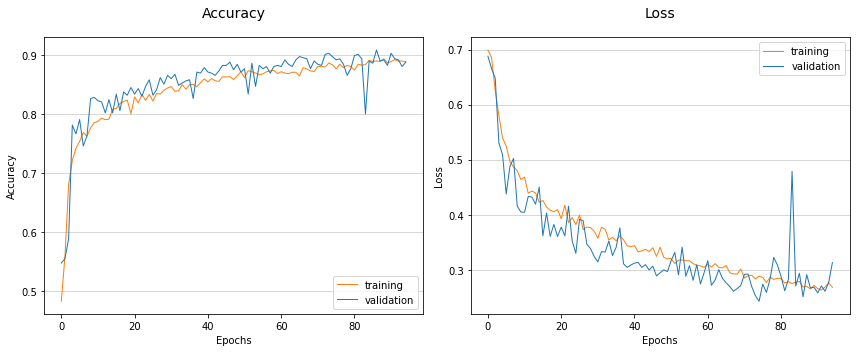

In [ ]:
ut.plot_training(history_mc.history['accuracy'], 
                    history_mc.history['loss'], 
                    history_mc.history['val_accuracy'], 
                    history_mc.history['val_loss'], 
                    95,
                    'figures/scratch_mc_32_4.png')

## Evaluation

In [ ]:
test_dataset, test_lab = ut.binarize(test_images, test_labels, 'mass_calcification')
test_dataset = ut.rescale(test_dataset)
test_dataset = np.expand_dims(test_dataset, axis=3)

In [ ]:
predicted = model.predict(test_dataset, verbose=1)
predicted = [0 if x <=0.5 else 1 for x in predicted]
ut.evaluate_classifier(test_lab, predicted)

11/11 [==============================] - 0s 19ms/step
Performances: 
Accuracy:  0.8690476190476191
Precision:  0.8690476190476191
Recall:  0.8690476190476191
F1-score:  0.8690476190476191
AUC:  0.8684837917660037


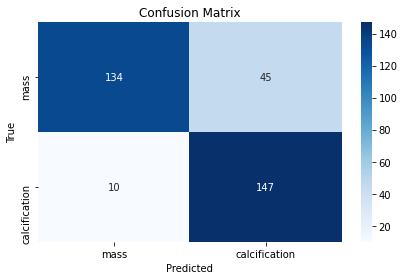

In [ ]:
ut.plot_confusion_matrix(test_lab, predicted, ['mass', 'calcification'], 'figures/scratch_mc_cm_32_4.png')